# Fake News Detection System
TF-IDF + Logistic Regression / Naive Bayes

In [2]:
# Install required packages
import subprocess
import sys

packages = ['pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn', 'nltk']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("All packages installed successfully!")


All packages installed successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [4]:
# Load datasets
fake_df = pd.read_csv('../data/Fake.csv')
real_df = pd.read_csv('../data/True.csv')

# Add labels
fake_df['label'] = 0  # Fake
real_df['label'] = 1  # Real

# Combine datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Identify text column
text_col = [col for col in df.columns if col.lower() in ['text', 'content', 'title']][0]

print(f'Dataset: {len(df)} samples (Fake: {(df["label"]==0).sum()}, Real: {(df["label"]==1).sum()})')

Dataset: 44898 samples (Fake: 23481, Real: 21417)


In [5]:
# Text preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())

df['cleaned_text'] = df[text_col].apply(preprocess_text)
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f'Preprocessing completed: {len(df)} samples')

Preprocessing completed: 44898 samples


In [6]:
# Train-test split
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 35918, Test: 8980


In [7]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

feature_names = np.array(tfidf.get_feature_names_out())
print(f'TF-IDF features: {X_train_tfidf.shape[1]}')

TF-IDF features: 5000


In [8]:
# Train models
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print('Models trained')

Models trained


In [14]:
# Evaluate models - Accuracy & Confusion Matrix
models = {'Logistic Regression': lr_model, 'Naive Bayes': nb_model}


for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f'\n{name}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))
   


Logistic Regression
Accuracy: 0.9508
Confusion Matrix:
[[4432  264]
 [ 178 4106]]
              precision    recall  f1-score   support

        Fake       0.96      0.94      0.95      4696
        Real       0.94      0.96      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980


Naive Bayes
Accuracy: 0.9389
Confusion Matrix:
[[4446  250]
 [ 299 3985]]
              precision    recall  f1-score   support

        Fake       0.94      0.95      0.94      4696
        Real       0.94      0.93      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



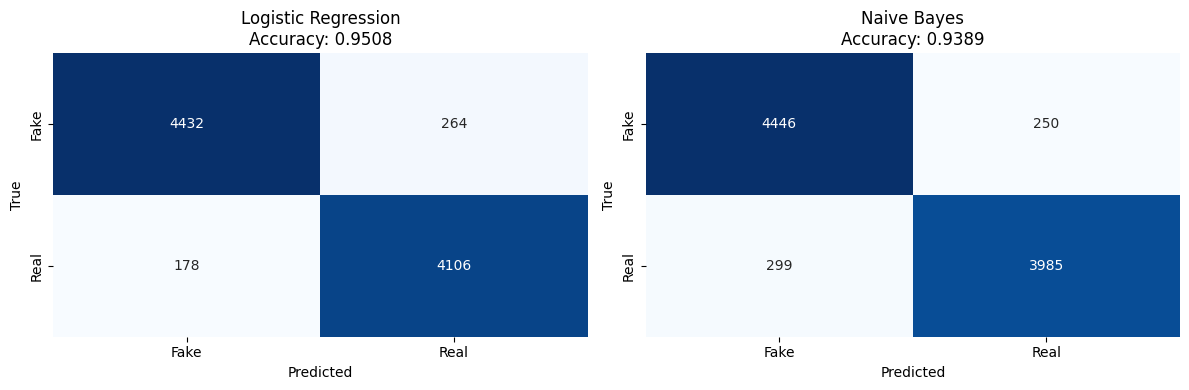

In [10]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'],
                ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy:.4f}')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [13]:
# Top Important Words
print('\nTOP IMPORTANT WORDS')

# Logistic Regression
coef = lr_model.coef_[0]
top_n = 10

print('\nLogistic Regression:')
print('\nFake News Indicators:')
fake_idx = np.argsort(coef)[:top_n]
for word in feature_names[fake_idx]:
    print(f'  {word}')

print('\nReal News Indicators:')
real_idx = np.argsort(coef)[-top_n:]
for word in feature_names[real_idx]:
    print(f'  {word}')

# Naive Bayes
print('\n\nNaive Bayes:')
log_probs = nb_model.feature_log_prob_

print('\nFake News Indicators:')
fake_idx_nb = np.argsort(log_probs[0])[-top_n:]
for word in feature_names[fake_idx_nb][::-1]:
    print(f'  {word}')

print('\nReal News Indicators:')
real_idx_nb = np.argsort(log_probs[1])[-top_n:]
for word in feature_names[real_idx_nb][::-1]:
    print(f'  {word}')


TOP IMPORTANT WORDS

Logistic Regression:

Fake News Indicators:
  video
  breaking
  watch
  the
  gop
  hillary
  just
  is
  and
  obamas

Real News Indicators:
  rohingya
  trump says
  pm
  talks
  brexit
  house
  china
  us
  factbox
  says


Naive Bayes:

Fake News Indicators:
  video
  to
  the
  trump
  of
  for
  in
  and
  is
  on

Real News Indicators:
  to
  us
  in
  trump
  says
  on
  of
  for
  house
  with


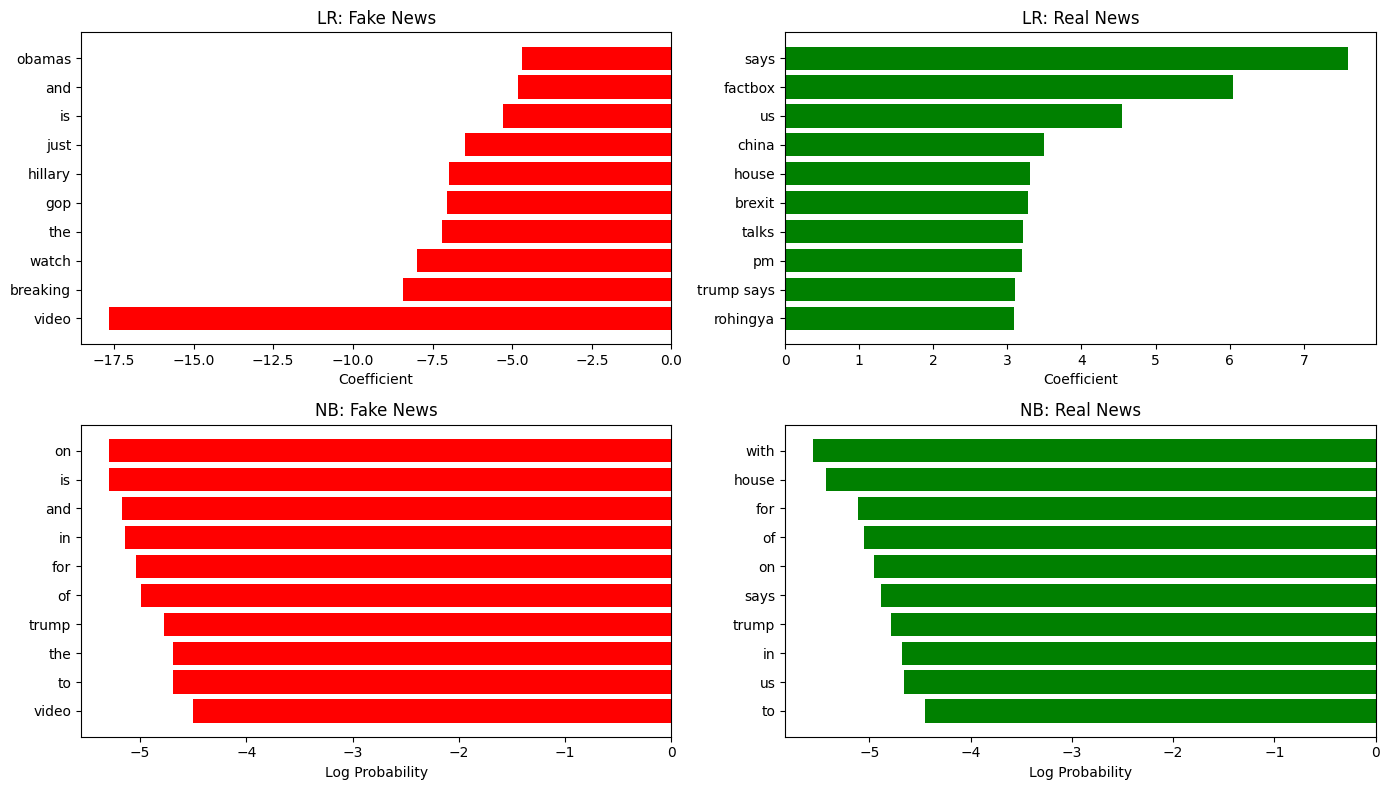

In [12]:
# Visualize Top Words
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

top_n = 10
coef = lr_model.coef_[0]

# LR - Fake
fake_idx = np.argsort(coef)[:top_n]
axes[0, 0].barh(feature_names[fake_idx], coef[fake_idx], color='red')
axes[0, 0].set_title('LR: Fake News')
axes[0, 0].set_xlabel('Coefficient')

# LR - Real
real_idx = np.argsort(coef)[-top_n:]
axes[0, 1].barh(feature_names[real_idx], coef[real_idx], color='green')
axes[0, 1].set_title('LR: Real News')
axes[0, 1].set_xlabel('Coefficient')

# NB - Fake
log_probs = nb_model.feature_log_prob_
fake_idx_nb = np.argsort(log_probs[0])[-top_n:][::-1]
axes[1, 0].barh(feature_names[fake_idx_nb], log_probs[0][fake_idx_nb], color='red')
axes[1, 0].set_title('NB: Fake News')
axes[1, 0].set_xlabel('Log Probability')

# NB - Real
real_idx_nb = np.argsort(log_probs[1])[-top_n:][::-1]
axes[1, 1].barh(feature_names[real_idx_nb], log_probs[1][real_idx_nb], color='green')
axes[1, 1].set_title('NB: Real News')
axes[1, 1].set_xlabel('Log Probability')

plt.tight_layout()
plt.show()